# How to predict a variable sinusoid
This notebook describes how to predict a variable sinusoid in Python.

Data analysed: Arrivals at tourist accommodation establishments extracted from https://ec.europa.eu/eurostat/web/tourism/data/database

## Data import and cleaning
Firstly, we read the CSV file and we select only data related to Italy (`df[df['geo'] == 'IT']`), in the form of numbers (`df[df['unit'] == 'NR']`) and referred to the sum of all data available (internal and external arrivals) (`df[df['c_resid'] == 'TOTAL']`).

Then we remove unuseful columns through the function `drop()`. Note that we pass the parameter `inplace=True` to store effects in the original variable `df`.

In [2]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/alod83/data-science/master/DataAnalysis/tourism/data/eurostat.csv')
df = df[df['geo'] == 'IT']
df = df[df['unit'] == 'NR']
df = df[df['c_resid'] == 'TOTAL']
df.drop(['c_resid', 'unit', 'nace_r2', '2019M11', 'geo'],axis=1, inplace=True)
df = df.reset_index()
df.drop(['index'],axis=1, inplace=True)
df

,2019M10,2019M09,2019M08,2019M07,2019M06,2019M05,2019M04,2019M03,2019M02,2019M01,2018M12,2018M11,2018M10,2018M09,2018M08,2018M07,2018M06,2018M05,2018M04,2018M03,2018M02,2018M01,2017M12,2017M11,2017M10,2017M09,2017M08,2017M07,2017M06,2017M05,2017M04,2017M03,2017M02,2017M01,2016M12,2016M11,2016M10,2016M09,2016M08,2016M07,...,1993M04,1993M03,1993M02,1993M01,1992M12,1992M11,1992M10,1992M09,1992M08,1992M07,1992M06,1992M05,1992M04,1992M03,1992M02,1992M01,1991M12,1991M11,1991M10,1991M09,1991M08,1991M07,1991M06,1991M05,1991M04,1991M03,1991M02,1991M01,1990M12,1990M11,1990M10,1990M09,1990M08,1990M07,1990M06,1990M05,1990M04,1990M03,1990M02,1990M01
0,7692388,9888817,11649500,11506828,10555177,8484623,7996564,6442451,5401907,4779780,5550186,5126598,7462294,10049088,11817246,11482751,10728751,9066367,8025649,6779476,5383709,4729026,5443284,4817633,7401129,9625706,11567765,11933697,10519951,8322918,8220021,6056440,5108877,4772747,5063842,4523557,7320777,9433150,11422615,11755553,...,4744921,3610510,2931744,2725903,2767519,2684279,4068006,5521645,6282531,5552620,5364437,5252192,4942875,3753232,3181039,2714727,2726843,2876177,4308688,5718601,6402220,5570098,5209197,4847278,4484347,4002596,2645773,2544782,2797069,2855961,4382114,5872800,6215162,5538456,5001834,4738376,5107712,3774702,2871632,2543920
1,9779634,13380878,17745906,16876623,15071334,11105855,10551748,7705290,6363443,5601494,6746571,6092158,9239898,13479976,17626911,16904374,14970839,12021528,10062451,8179351,6324516,5462541,6543802,5613342,9112491,12730985,17239893,17501766,14709300,10545765,10632882,7066042,5962207,5537081,6009629,5178930,8887426,12279511,16848242,16996293,...,5127092,3743947,3043936,2844002,2921727,2763080,4246336,6226681,8709014,7537564,6389438,5776712,5328170,3881583,3302808,2813833,2867173,2968577,4511602,6425817,8758652,7664457,6193919,5329908,4759920,4231367,2748309,2640526,2942066,2935436,4574465,6553683,8412912,7430910,5995222,5169499,5498973,3925870,2982746,2635664
2,1800880,2620422,4080752,3653490,3041263,2007128,1975162,1170226,910129,785658,1109352,919579,1527968,2462361,3716305,3255432,2732531,2089580,1532026,1216664,896587,684507,1015398,756158,1438203,2203804,3474068,3417748,2535052,1620720,1744140,937793,799205,721506,866338,626990,1312492,1951170,3202887,3106669,...,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:
3,2087246,3492061,6096406,5369795,4516157,2621232,2555184,1262839,961536,821714,1196385,965560,1777604,3430888,5809665,5421623,4242088,2955161,2036802,1399875,940807,733515,1100518,795709,1711362,3105279,5672128,5568069,4189349,2222847,2412861,1009602,853330,764334,945787,655373,1566649,2846361,5425627,5240740,...,382171,133437,112192,118099,154208,78801,178330,705036,2426483,1984944,1025001,524520,385295,128351,121769,99106,140330,92400,202914,707216,2356432,2094359,984722,482630,275573,228771,102536,95744,144997,79475,192351,680883,2197750,1892454,993388,431123,391261,151168,111114,91744
4,286366,871639,2015654,1716305,1474894,614104,580022,92613,51407,36056,87033,45981,249636,968527,2093360,2166191,1509557,865581,504776,183211,44220,49008,85120,39551,273159,901475,2198060,2150321,1654297,602127,668721,71809,54125,42828,79449,28383,254157,895191,2222740,2134071,...,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:,:


Now we can correct some errors in data: some rows contain the character `:`, which means no data available. Other rows contain the letter `b`. We change `:` in `0` and we remove the letter `b`.

In [0]:
columns = df.columns[::-1]
for column in columns:
    for row in range(1, len(df[column])):
        if "b" in df[column][row]:
            df[column] = df[column][row][:-2]
        if ":" in df[column][row]:
            df[column][row] = "0"

Now we calculate the sum over the columns, in order to get the total number of arrivals for each month. We store results in the variable `y`.

In [0]:
y = []
for column in columns:
    df[column] = df[column].astype(str).astype(int)
    y.append(df[column].sum())

## Preliminary analysis
We plot `y` to understand the trendline. We build the auxiliary vector `X`, which contains all the months. Month 0 refers to 1990 Genuary. In order to display x labels in the graph every 5 years, we build two auxiliary variables, `x_ticks` and `x_labels`.

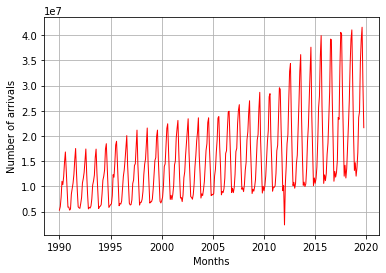

In [6]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np


X = np.arange(0, len(columns))

step = 5
x_ticks = np.arange(0, len(columns)+step, step=12*step)
x_labels = []
x_labels.append(1990)
for i in range(1, len(x_ticks)+1):
    x_labels.append(x_labels[i-1]+step)
plt.xticks(x_ticks, x_labels)
plt.plot(X, y, color="red", linewidth=1)

plt.grid()
plt.xlabel('Months')
plt.ylabel('Number of arrivals')

plt.show()

We note that over the last 8 years there was an increase of the maximum peaks, with respect to the previous years. Thus we limit our analysis the last 8 years. This means that we should skip the first 22 years. We reset `X` and `y` to work only with the last years.

In [0]:
skip = 22*12
X = X[skip:]
y = y[skip:]

## Data approximation
Now we can approximate data with a sinusoid. The equation of a sinusoid is `A*np.sin(omega*x+phase) + offset`, where:
* |`A`| indicates the amplitude, i.e. half the distance between the maximum and minimum values of the function
* `omega` is the number of cycles between 0 and 2pi. The period T is 2pi/omega
* `phase` is the horizontal shift
* `offset` is the vertical shift, i.e. the sum between the minimum peak and the amplitude. Here some details about offset: https://www.ck12.org/book/ck-12-precalculus-concepts/section/5.4/

For more details about sinusoids, you can give a look at: https://mathbitsnotebook.com/Algebra2/TrigGraphs/TGsinusoidal.html

In [0]:
def sinusoid(x,A,offset,omega,phase):
    return A*np.sin(omega*x+phase) + offset

We define also initial values for the sinusoid. We set the period `T = 12`, i.e. the number of months in a year. If the period is not known, we should calculate it. We could use the Fast Fourier Transform. At these links you can find more details about this aspect: https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy, https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html and https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html.

In [0]:
T = 12
def get_p0(x, y):
    
    A0 = (max(y[0:T]) - min(y[0:T]))/2
    offset0 = y[0]
    phase0 = 0
    omega0 = 2.*np.pi/T
    return [A0, offset0,omega0, phase0]

Now we are ready to approximate our data with a sinusoid. We use the `curve_fit()` function provided by `scipy`. The we plot results. For more details about the `curve_fit()` function, please give a look at https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html.

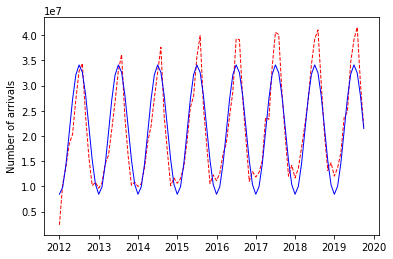

In [11]:
from scipy.optimize import curve_fit
import math

param, covariance = curve_fit(sinusoid, X, y, p0=get_p0(X,y))

step = 1
x_ticks = np.arange(skip, skip+len(X)+step+12, step=12*step)
x_labels = []
x_labels.append(2012)
for i in range(1, len(x_ticks)+13):
    x_labels.append(x_labels[i-1]+step)
plt.xticks(x_ticks, x_labels)
plt.ylabel('Number of arrivals')
plt.plot(X, y, color="red", linewidth=1,linestyle='dashed')
plt.plot(X, sinusoid(X, *param), color="blue", linewidth=1)
plt.show()

We have approximated our data with a sinusoid with a constant value of `A`. In our case both the amplitude `A` and the `offset` are variable. The idea is to calculate all the maximum peaks and minimum peaks in our data. Then we can use their difference to calculate the vector of amplitudes and pass them to the `sinusoid()` function.

We define the function `get_peaks()`, which calculates the peaks of an array. We sample the array every `T` elements and we calculate the peak within each `T`.

In [0]:
def get_peaks(y, metrics):
    n = int(math.ceil(len(y)/T))
    step = 0
    x_peaks = []
    y_peaks = []
    for i in range(0,n):
        peak_index = y.index(metrics(y[step:step+T]))
        x_peaks.append(peak_index + skip)
        y_peaks.append(y[peak_index])
        step = step+T
    return [x_peaks,y_peaks]

We calculate the maximum and minimum peaks.

In [0]:
# approximate curve of peaks with
min_peaks = get_peaks(y,min)
max_peaks = get_peaks(y,max)

Now we can calculate the array of amplitudes and offsets.

In [0]:
#calculate variable amplitude and variable offset
A = []
offset = []
for i in range(0, len(min_peaks[1])):
    c_a = (max_peaks[1][i] - min_peaks[1][i])/2
    c_offset = min_peaks[1][i] + c_a
    for j in range(0,T):
        A.append(c_a)
        offset.append(c_offset)
# last two months of 2019 are not available
A = A[:-2]
offset = offset[:-2]

Since `A` and `offset` are new features, we should add them as variables. Thus we define a new variable `features`, which defines the new input features of our model. Then we define the function `variable_sinusoid()`, which takes the features as input. 

The only parameters returned by our model are `omega` and `phase` thus we modify also the function `get_p0()` with initial values of `omega` and `phase`. The new function is called `variable_get_p0()`.

In [0]:
features = [X, A, offset]

def variable_sinusoid(features,omega,phase):
    x = features[0]
    A = features[1]
    offset = features[2]
    return A*np.sin(omega*x+phase) + offset

def variable_get_p0(x, y): 
    phase0 = 0
    omega0 = 2.*np.pi/T
    return [omega0, phase0]

We fit the model and plot results.

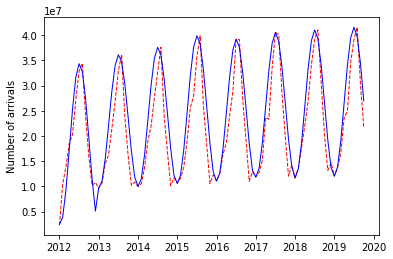

In [16]:
param, covariance = curve_fit(variable_sinusoid, features, y, p0=variable_get_p0(X,y))

plt.xticks(x_ticks, x_labels)
plt.ylabel('Number of arrivals')
plt.plot(X, y, color="red", linewidth=1,linestyle='dashed')
plt.plot(X, variable_sinusoid(features, *param), color="blue", linewidth=1)
plt.show()

## Predicting the future trendline
The next step involves the prediction of the next sinusoid, i.e. the sinusoid for year 2020. In order to do it, we need to calculate the next max and minimum peaks. We can do it by approximating the vector of maximum and minimum peaks with two linear regressions, respectively. Then, we can calculate the maximum peak at instant i (August 2020) as the y value of the maximum linear regression given at instant (i-1) + pi (i-1 represents August 2019). Similarly, we can calculate the minimum peak for year 2020.

Firstly, we reshape the peaks to be passed to the linear model. Then, we build two linear models, one for each predicting line, using the `sklearn` class `LinearRegression()`. After that, we fit every model using the `fit()` function.

In [17]:
from sklearn import linear_model

# reshape x_peaks
x_min_peaks = list(map(lambda el:[el], min_peaks[0])) 
x_max_peaks = list(map(lambda el:[el], max_peaks[0])) 

# min model
model_min = linear_model.LinearRegression()
model_min.fit(x_min_peaks,min_peaks[1])

# max model
model_max = linear_model.LinearRegression()
model_max.fit(x_max_peaks,max_peaks[1])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

We append the next peaks both to `x_max_peaks` and `x_min_peaks` and then we predict the maximum and minimum peaks through the `predict()` function.

In [0]:
x_min_peaks.append([x_min_peaks[len(x_min_peaks) -1][0] + T])
x_max_peaks.append([x_max_peaks[len(x_max_peaks) -1][0] + T])
y_pred_min = model_min.predict(x_min_peaks)
y_pred_max = model_max.predict(x_max_peaks)

We plot the two predicting lines.

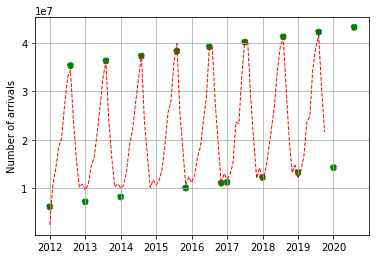

In [19]:
plt.xticks(x_ticks, x_labels)
plt.plot(X, y, color="red", linewidth=1,linestyle='dashed')
plt.scatter(x_min_peaks, y_pred_min, color="green", linewidth=1,linestyle='dashed')
plt.scatter(x_max_peaks, y_pred_max, color="green", linewidth=1,linestyle='dashed')
plt.ylabel('Number of arrivals')
plt.grid()
plt.show()

We calculate the sinusoid for all the period, including 2020. We build a variable `X_pred`, which contains `X` and the 12 months of 2020.

In [0]:
X_pred = np.array(X)
month = X_pred[len(X_pred)-1]
for i in range(0,T):
    X_pred = np.append(X_pred,month)
    month = month + 1

Now, we can update the variable `features_pred` to be passed to the `variable_sinusoid()` function. Firstly, we update the amplitude `A` and the `offset` with new values and then we update the `features_pred` variable.

In [0]:
index = len(max_peaks[0])-1
c_a = (max_peaks[1][index] - min_peaks[1][index])/2
c_offset = min_peaks[1][index] + c_a
for j in range(0,T):
        A.append(c_a)
        offset.append(c_offset)

features_pred = [X_pred,A,offset]

Finally, we plot graphs.

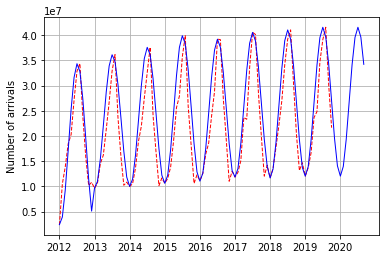

In [22]:
plt.xticks(x_ticks, x_labels)
plt.plot(X, y, color="red", linewidth=1,linestyle='dashed')
plt.plot(X_pred, variable_sinusoid(features_pred, *param), color="blue", linewidth=1)
plt.grid()
plt.ylabel('Number of arrivals')
plt.savefig("data/sinusoid.png")
plt.show()

We also export predictions to a CSV file.

In [0]:
import csv

table = []
y_pred = variable_sinusoid(features_pred, *param)
for i in range(0, len(X_pred)):
    row = { 'x' : X_pred[i], 'y' : y_pred[i]}
    table.append(row)

names = table[0].keys()
with open('data/arrivals_prediction.csv', 'w') as output_file:
    dict_writer = csv.DictWriter(output_file, names)
    dict_writer.writeheader()
    dict_writer.writerows(table)